<a href="https://colab.research.google.com/github/fdzcampos/titanic/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic


In [ ]:
!pip install optuna

In [ ]:
from google.colab import files

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import impute

from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

from sklearn import metrics

import optuna

import time

## Data

In [ ]:
files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


{'test.csv': b'PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked\r\n892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q\r\n893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7,,S\r\n894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,,Q\r\n895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,,S\r\n896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,,S\r\n897,3,"Svensson, Mr. Johan Cervin",male,14,0,0,7538,9.225,,S\r\n898,3,"Connolly, Miss. Kate",female,30,0,0,330972,7.6292,,Q\r\n899,2,"Caldwell, Mr. Albert Francis",male,26,1,1,248738,29,,S\r\n900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18,0,0,2657,7.2292,,C\r\n901,3,"Davies, Mr. John Samuel",male,21,2,0,A/4 48871,24.15,,S\r\n902,3,"Ilieff, Mr. Ylio",male,,0,0,349220,7.8958,,S\r\n903,1,"Jones, Mr. Charles Cresson",male,46,0,0,694,26,,S\r\n904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23,1,0,21228,82.2667,B45,S\r\n905,2,"Howard, Mr. Benja

In [ ]:
train = pd.read_csv('train.csv', index_col= 0)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test = pd.read_csv('test.csv', index_col= 0)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Exploring the data

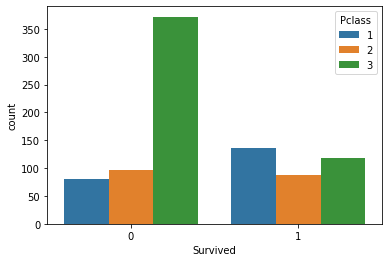

In [ ]:
sns.countplot(x= 'Survived', data= train, hue= 'Pclass')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


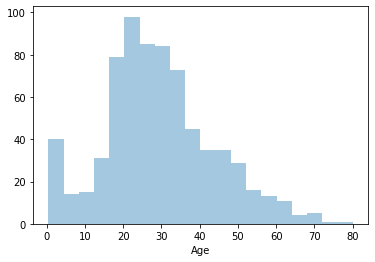

In [ ]:
sns.distplot(train['Age'].dropna(), kde= False)

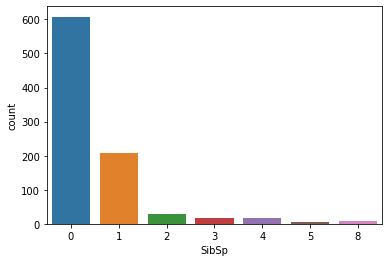

In [ ]:
sns.countplot(x= 'SibSp', data= train)

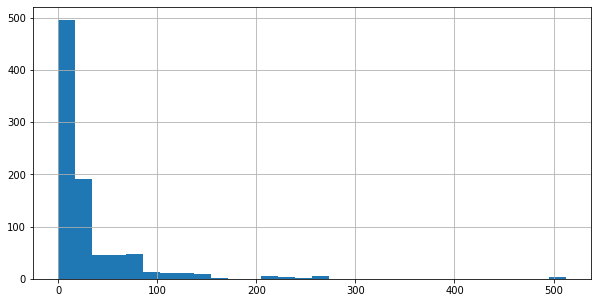

In [ ]:
train['Fare'].hist(bins= 30, figsize= (10, 5))

### Cleaning data

In [ ]:
sex = pd.get_dummies(train['Sex'], drop_first= True)
embarked = pd.get_dummies(train['Embarked'], drop_first= True)

train = pd.concat([train, sex, embarked], axis= 1)
train['embarked_queenstown'] = train['Q']
train['embarked_southampton'] = train['S']
train.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'Q', 'S'], axis= 1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,male,embarked_queenstown,embarked_southampton
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,NaN,1,0,1
2,1,1,38.0,1,0,71.2833,C85,0,0,0
3,1,3,26.0,0,0,7.9250,NaN,0,0,1
4,1,1,35.0,1,0,53.1000,C123,0,0,1
5,0,3,35.0,0,0,8.0500,NaN,1,0,1


#### Imputing missing data

In [ ]:
train.isna().sum()

Survived                  0
Pclass                    0
Age                     177
SibSp                     0
Parch                     0
Fare                      0
Cabin                   687
male                      0
embarked_queenstown       0
embarked_southampton      0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              891 non-null    int64  
 1   Pclass                891 non-null    int64  
 2   Age                   714 non-null    float64
 3   SibSp                 891 non-null    int64  
 4   Parch                 891 non-null    int64  
 5   Fare                  891 non-null    float64
 6   Cabin                 204 non-null    object 
 7   male                  891 non-null    uint8  
 8   embarked_queenstown   891 non-null    uint8  
 9   embarked_southampton  891 non-null    uint8  
dtypes: float64(2), int64(4), object(1), uint8(3)
memory usage: 58.3+ KB


In [ ]:
train.drop('Cabin', axis= 1, inplace= True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,embarked_queenstown,embarked_southampton
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1


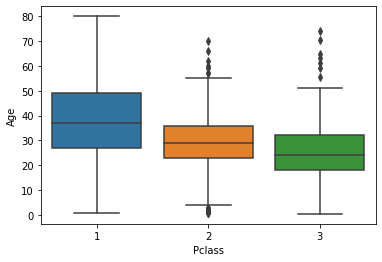

In [ ]:
sns.boxplot(x= 'Pclass', y= 'Age', data= train)

In [ ]:
imputer = impute.SimpleImputer(missing_values= np.nan, strategy= 'mean')

imputer.fit(train[train['Pclass'] == 1])
train[train['Pclass'] == 1 ] = imputer.transform(train[train['Pclass'] == 1])

imputer.fit(train[train['Pclass'] == 2])
train[train['Pclass'] == 2 ] = imputer.transform(train[train['Pclass'] == 2])

imputer.fit(train[train['Pclass'] == 3])
train[train['Pclass'] == 3 ] = imputer.transform(train[train['Pclass'] == 3])

In [ ]:
train.isna().sum()

Survived                0
Pclass                  0
Age                     0
SibSp                   0
Parch                   0
Fare                    0
male                    0
embarked_queenstown     0
embarked_southampton    0
dtype: int64

In [ ]:
# train.dropna(inplace= True)

In [ ]:
x = train.drop('Survived', axis= 1)
y = train['Survived']

## Modelo

In [ ]:
randstate = 222

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= randstate)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.2, random_state= randstate)

x_train.shape, x_val.shape, x_test.shape

((498, 8), (125, 8), (268, 8))

In [ ]:
# dataframes with all the information of each model
summary = {
    'logistic_regression': pd.DataFrame(columns=['Time (sec)', 'Score (RMSE)']),
    'random_forest': pd.DataFrame(columns=['Time (sec)', 'Score (RMSE)', 'Min. samples split', 'Criterion', 'Max. depth', 'N. estimators','Max. features']),
    'gradient_boosting': pd.DataFrame(columns=['Time (sec)', 'Score (RMSE)'])
}

#### Logistic Regression

In [ ]:
start = time.time()

lmodel = LogisticRegression()
lmodel.fit(x_train, y_train)

preds = lmodel.predict(x_test)

end = time.time()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
summary['logistic_regression'] = summary['logistic_regression'].append(
    pd.Series({
        'Time (sec)': '{:4f}'.format(end - start),
        'Score (RMSE)': metrics.mean_squared_error(y_test, preds)**0.5
      }, 
      name= 'log_reg')
    )

summary['logistic_regression']

,Time (sec),Score (RMSE)
log_reg,0.049070,0.444703


In [ ]:
print(metrics.classification_report(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       163
         1.0       0.76      0.72      0.74       105

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

[[139  24]
 [ 29  76]]


In [ ]:
pred_prob = lmodel.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)

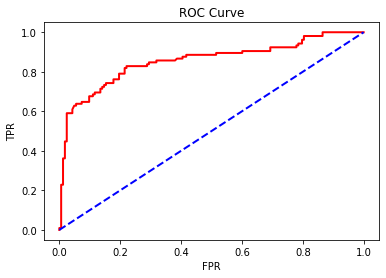

In [ ]:
plt.plot(fpr, tpr, color= 'red', lw= 2, label= 'ROC Curve')
plt.plot([0, 1], [0, 1], color= 'blue', lw= 2, linestyle= '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

#### Random Forest

In [ ]:
n_jobs = 2
verbose = 1

##### Default parameters

In [ ]:
rf = ensemble.RandomForestRegressor(random_state=randstate, verbose=verbose, n_jobs=n_jobs)

start = time.time()

rf = rf.fit(x_train, y_train)

preds = rf.predict(x_test)
score =  metrics.mean_squared_error(y_test, preds)**0.5

end = time.time()

summary['random_forest'] = summary['random_forest'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end - start), 
    'Score (RMSE)': score,
    'Min. samples split': 2, 
    'Criterion': 'gini', 
    'Max. depth': 'None',
    'N. estimators': 100,
    'Max. features': 1
    },
    name='default'))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
summary['random_forest']

,Time (sec),Score (RMSE),Min. samples split,Criterion,Max. depth,N. estimators,Max. features
default,0.3577,0.389747,2,gini,None,100,1


##### Tuning parameters with optuna

In [ ]:
import sys

In [ ]:
min_max_depth = 2
max_max_depth = 32

min_n_estimators = 50
max_n_estimators = 400

criterions = ['squared_error', 'absolute_error', 'poisson']

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', min_n_estimators, max_n_estimators)
  max_depth = trial.suggest_int('max_depth', min_max_depth, max_max_depth)
  min_samples_split = trial.suggest_uniform('min_samples_split', 0+sys.float_info.min, 1)
  max_features = trial.suggest_uniform('max_features', 0+sys.float_info.min, 0.6)
  criterion = trial.suggest_categorical('criterion', criterions)

  rf = ensemble.RandomForestRegressor(random_state=randstate, 
                                      max_depth= max_depth,
                                      n_estimators= n_estimators,   
                                      criterion= criterion,
                                      min_samples_split= min_samples_split,
                                      max_features= max_features,                           
                                      verbose= verbose, n_jobs= n_jobs)

  rf = rf.fit(x_train, y_train)

  val_pred = rf.predict(x_val)

  return metrics.mean_squared_error(y_val, val_pred) ** .5


start = time.time()
rf_optuna = optuna.create_study(direction= 'minimize')
rf_optuna.optimize(objective, n_trials= 100)
end = time.time()

summary['random_forest'] = summary['random_forest'].append(pd.Series({
    'Time (sec)': '{:.4f}'.format(end - start), 
    'Score (RMSE)': rf_optuna.best_value,
    'Min. samples split': rf_optuna.best_params['min_samples_split'] , 
    'Criterion': rf_optuna.best_params['criterion'], 
    'Max. depth': rf_optuna.best_params['max_depth'],
    'N. estimators': rf_optuna.best_params['n_estimators'],
    'Max. features': rf_optuna.best_params['max_features']
    },
    name='optuna'))

[I 2021-12-02 10:30:33,928] A new study created in memory with name: no-name-05d73aef-d22b-4d6f-9745-020513993ce3
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 193 out of 193 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 193 out of 193 | elapsed:    0.1s finished
[I 2021-12-02 10:30:34,425] Trial 0 finished with value: 0.42779138163662855 and parameters: {'n_estimators': 193, 'max_depth': 9, 'min_samples_split': 0.5050225917232787, 'max_features': 0.3231635604524075, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.42779138163662855.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 task

In [ ]:
summary['random_forest']

,Time (sec),Score (RMSE),Min. samples split,Criterion,Max. depth,N. estimators,Max. features
default,0.3577,0.389747,2,gini,None,100,1
optuna,70.9472,0.362984,0.0614486,squared_error,13,282,0.599295


### Choosing best model

In [ ]:
summary['logistic_regression']

,Time (sec),Score (RMSE)
log_reg,0.049070,0.444703


In [ ]:
summary['random_forest']

,Time (sec),Score (RMSE),Min. samples split,Criterion,Max. depth,N. estimators,Max. features
default,0.3577,0.389747,2,gini,None,100,1
optuna,70.9472,0.362984,0.0614486,squared_error,13,282,0.599295


## Entrega

In [ ]:
test = pd.read_csv('test.csv', index_col= 0)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
sex = pd.get_dummies(test['Sex'], drop_first= True)
embarked = pd.get_dummies(test['Embarked'], drop_first= True)

test = pd.concat([test, sex, embarked], axis= 1)
test['embarked_queenstown'] = test['Q']
test['embarked_southampton'] = test['S']
test.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'Q', 'S', 'Cabin'], axis= 1, inplace=True)
test.head()

,Pclass,Age,SibSp,Parch,Fare,male,embarked_queenstown,embarked_southampton
PassengerId,,,,,,,,
892,3,34.5,0,0,7.8292,1,1,0
893,3,47.0,1,0,7.0000,0,0,1
894,2,62.0,0,0,9.6875,1,1,0
895,3,27.0,0,0,8.6625,1,0,1
896,3,22.0,1,1,12.2875,0,0,1


In [ ]:
test.isna().sum()

Pclass                   0
Age                     86
SibSp                    0
Parch                    0
Fare                     1
male                     0
embarked_queenstown      0
embarked_southampton     0
dtype: int64

In [ ]:
imputer.fit(test[test['Pclass'] == 1])
test[test['Pclass'] == 1 ] = imputer.transform(test[test['Pclass'] == 1])

imputer.fit(test[test['Pclass'] == 2])
test[test['Pclass'] == 2 ] = imputer.transform(test[test['Pclass'] == 2])

imputer.fit(test[test['Pclass'] == 3])
test[test['Pclass'] == 3 ] = imputer.transform(test[test['Pclass'] == 3])

In [ ]:
test['Fare'].fillna(test['Fare'].mean(), inplace= True)

In [ ]:
x = train.drop('Survived', axis= 1)
y = train['Survived']

x.shape, y.shape, test.shape

((891, 8), (891,), (418, 8))

In [ ]:
rf_opt_predict = rf_best_optuna.predict(test)

In [ ]:
rf_opt_predict = np.where(np.array(rf_opt_predict) > .5, 1, 0)
df = pd.DataFrame(rf_opt_predict)
df.insert(0, 'PassengerId', test.index)
df.columns = ['PassengerId', 'Survived']
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
df.to_csv('titanic_entrega.csv', index= False)